### Investigate future prediction capacity of trained models
Evaluate the ability of trained models optimized for next timestep (i.e. 1 step ahead) prediction to generalize to predicting longer horizons (i.e. an arbitrary number of future timesteps).

In [42]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import torch
from data._utils import load_Uzel2022, load_Skora2018, load_Flavell2023, load_Leifer2023
from models._main import get_model
from models._utils import *
from omegaconf import OmegaConf
from utils import DEVICE

In [43]:
# Load a trained model from the config file (simpler)

# load config
config_path = "../logs/hydra/2023_06_16_10_45_02/3/config.yaml"
config = OmegaConf.load(config_path)
print("config:", OmegaConf.to_yaml(config), end="\n\n")

# checkpoint path
checkpoint_path = config.model.checkpoint_path
print("checkpoint path:", checkpoint_path, end="\n\n")

# training params
epoch = config.train.epochs
seq_len = config.train.seq_len
tau = config.train.tau_in
smooth_data = config.globals.smooth_data

# names
model_name = config.model.type
train_dataset_name = config.dataset.name

# print info
print(
    "{} model was trained on dataset {} containing sequences of length "
    "{} for {} epochs to predict {} timesteps into the future.".format(
        model_name,
        train_dataset_name,
        seq_len,
        epoch,
        tau,
    ),
    end="\n\n",
)

# load the pretrained model
model = get_model(config)
model.eval()

config: preprocess:
  url: https://www.dropbox.com/s/5r5cyxoads3iglz/opensource_data.zip?dl=1
  zipfile: opensource_data.zip
  dataset: all
  raw_dir: data/raw
  resample_dt: 0.1
  smooth: FFT
dataset:
  name: Flavell2023_Kaplan2020_Kato2015_Leifer2023_Nichols2017_Skora2018_Uzel2022
model:
  type: NetworkLSTM
  input_size: 302
  hidden_size: 256
  num_layers: 1
  loss: MSE
  fft_reg_param: 0.0
  l1_reg_param: 0.0
  checkpoint_path: logs/hydra/2023_06_16_10_45_02/3/checkpoints/1000_epochs_246000_worms.pt
train:
  optimizer: Adagrad
  learn_rate: 0.01
  epochs: 1000
  save_freq: 1000
  seq_len: 200
  k_splits: 2
  num_samples: 16
  num_batches: 1
  tau_in: 1
  shuffle_samples: false
  reverse: false
predict:
  tau_out: 1000
  context_len: 200
  model:
    checkpoint_path: logs/hydra/2023_06_16_10_45_02/3/checkpoints/1000_epochs_246000_worms.pt
  dataset:
    name: Flavell2023
visualize:
  log_dir: logs/hydra/2023_06_16_10_45_02/3
  worm: worm0
  neuron: AVAL
globals:
  random_seed: 1
  u

Model checkpoint path: /net/vast-storage/scratch/vast/yanglab/qsimeon/worm-graph/logs/hydra/2023_06_16_10_45_02/3/checkpoints/1000_epochs_246000_worms.pt

Model: NetworkLSTM(
  (identity): Identity()
  (linear): Linear(in_features=256, out_features=302, bias=True)
  (lstm): LSTM(302, 256, batch_first=True)
)



NetworkLSTM(
  (identity): Identity()
  (linear): Linear(in_features=256, out_features=302, bias=True)
  (lstm): LSTM(302, 256, batch_first=True)
)

In [44]:
# Ideally evaluate the model on a test dataset that it was not trained on

# test_dataset = load_Uzel2022()  # dataset of multiple worms
test_dataset = load_Skora2018()  # dataset of multiple worms
# test_dataset = load_Flavell2023()  # dataset of multiple worms
# test_dataset = load_Leifer2023()  # dataset of multiple worms

# determine if the test dataset was seen during training
test_dataset_name = test_dataset["worm0"]["dataset"]
in_distribution = test_dataset_name in train_dataset_name
dataset_inclusion_str = int(not in_distribution) * "un" + "familiar"
print(
    "The (train) dataset(s) the model was trained on:", train_dataset_name, end="\n\n"
)
print("The (test) dataset(s) to make predictions on:", test_dataset_name, end="\n\n")
print("Was the test dataset seen during training?", "YES" if in_distribution else "NO")

The (train) dataset(s) the model was trained on: Flavell2023_Kaplan2020_Kato2015_Leifer2023_Nichols2017_Skora2018_Uzel2022

The (test) dataset(s) to make predictions on: Skora2018

Was the test dataset seen during training? YES


In [45]:
# Get values from the test dataset to use for prediciton and plots

print("Smooth data?", smooth_data, end="\n\n")
named_neurons_mask = test_dataset["worm0"]["named_neurons_mask"]
if smooth_data:
    calcium_data = test_dataset["worm0"]["smooth_calcium_data"]
else:
    calcium_data = test_dataset["worm0"]["calcium_data"]
time_in_seconds = test_dataset["worm0"]["time_in_seconds"]
max_timesteps = test_dataset["worm0"]["max_timesteps"]
slot_to_named_neuron = test_dataset["worm0"]["slot_to_named_neuron"]

Smooth data? True



In [46]:
# Investigate the model's ability to complete a sequence

input_len = 300
new_timesteps = 200
context_len = 100
start_time_slice = range(0, input_len)
future_time_slice = range(input_len, input_len + new_timesteps)
complete_time_slice = range(0, input_len + new_timesteps)

input_ = calcium_data[start_time_slice, :]
target = calcium_data[future_time_slice, :]

# put on device
model = model.to(DEVICE)
input_ = input_.to(DEVICE)

output = (
    model.generate(
        input_,
        new_timesteps,
        context_len=context_len,
        mask=named_neurons_mask,
    )
    .cpu()
    .squeeze(0)
)

input length: 300 
context length: 100 
future timesteps: 200



In [57]:
# Pick one of the labeled neurons in the test dataset to inspect

named_neuron_inds = torch.where(named_neurons_mask)[0].numpy()
nidx = np.random.choice(named_neuron_inds)  # pick a neuron to plot (random)
# nidx = 53  # index for neuron AVAL (consistent)
neuron_name = slot_to_named_neuron[nidx]

print("number of labeled neurons:", sum(named_neurons_mask).item())
print("picked neuron index:", nidx)
print("picked neuron name:", neuron_name)

number of labeled neurons: 40
picked neuron index: 22
picked neuron name: ALA


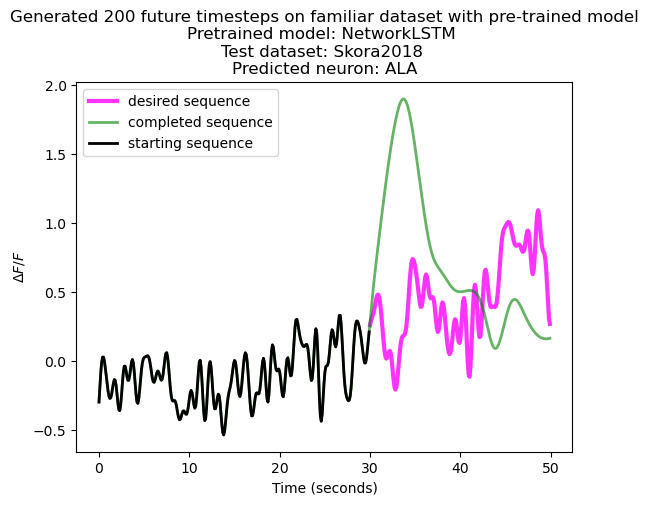

In [58]:
# Plot what the generations versus real data look like

plt.plot(
    time_in_seconds[future_time_slice],
    target[:, nidx],
    color="magenta",
    label="desired sequence",
    alpha=0.8,
    linewidth=3,
)

plt.plot(
    time_in_seconds[complete_time_slice],
    output[:, nidx],
    color="green",
    label="completed sequence",
    alpha=0.6,
    linewidth=2,
)

plt.plot(
    time_in_seconds[start_time_slice],
    input_[:, nidx],
    color="black",
    label="starting sequence",
    alpha=1.0,
    linewidth=2,
)

plt.legend()
plt.xlabel("Time (seconds)")
plt.ylabel("$\Delta F / F$")
# plt.ylim([-3.0, 3.0])
plt.title(
    "Generated %s future timesteps on %s dataset with pre-trained model\nPretrained model: %s \nTest dataset: %s \nPredicted neuron: %s"
    % (
        new_timesteps,
        dataset_inclusion_str,
        model_name,
        test_dataset_name,
        neuron_name,
    )
)
plt.show()